In [141]:
import  numpy as np 
import math , random 
from tqdm import tqdm
import matplotlib.pyplot as plt

In [142]:
max_t = 1000
delta_t = 0.02
feature_len = 2 



sequence_len = 20 
predict_len = 5 

In [143]:
def ladybug_initial(s=122) : 
    
    if s > 0 :  random.seed(s)
    ladybug_initial.param_x = [random.gauss(0., 1.) for u in range(8)]
    ladybug_initial.param_y = [random.gauss(0., 1.) for u in range(8)]


def ladybug_deplace(t) : 
    k = 0.5 
    
    [ax1,ax2,ax3,ax4, kx1, kx2, kx3, kx4] = ladybug_initial.param_x
    [ay1,ay2,ay3,ay4, ky1, ky2, ky3,ky4] = ladybug_initial.param_y
    
    
    
    x = ax1*math.sin(t*(kx1+20)) + ax2*math.cos(t*(kx2+10))+ ax3*math.sin(t*(kx3+5)) + ax4*math.cos(t*(kx4+5)) 
    y = ay1*math.cos(t*(ky1+20)) + ay2*math.sin(t*(ky2+10))+ ay3*math.cos(t*(ky3+5)) + ay4*math.sin(t*(ky4+5))
    
    
    return x,y

In [144]:

ladybug_initial(s=16)
x,y = 0,0
positions=[]
for t in tqdm(np.arange(0., 1000, 0.01)):
    x,y = ladybug_deplace(t)
    positions.append([x,y])


n = int( len(positions)*.2 )
dataset = np.array(positions[:n])

k = int(len(dataset)* .8)
x_train = dataset[:k]
x_test  = dataset[k:]


mean = x_train.mean()
std  = x_train.std()
x_train = (x_train - mean) / std
x_test  = (x_test  - mean) / std

print("Dataset generated.")
print("Train shape is : ", x_train.shape)
print("Test  shape is : ", x_test.shape)


100%|██████████| 100000/100000 [00:00<00:00, 114798.27it/s]

Dataset generated.
Train shape is :  (16000, 2)
Test  shape is :  (4000, 2)


## NORMALISATION 

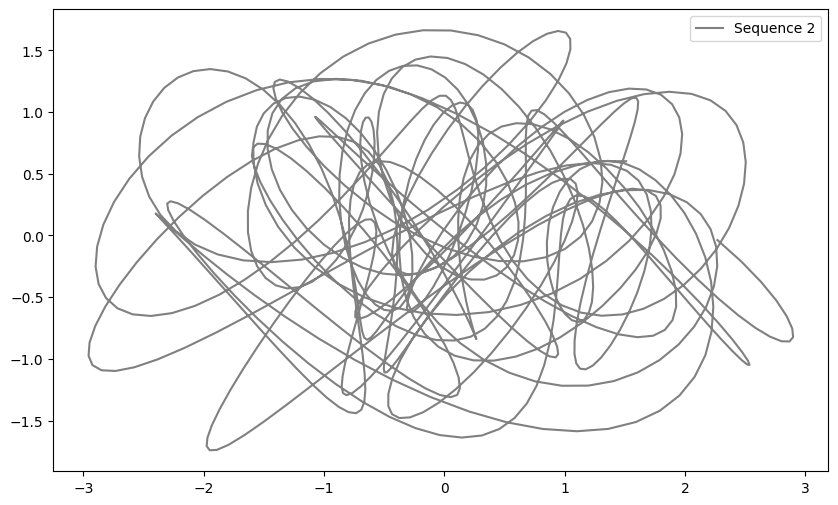

In [145]:
def segment_2d(sequence2, ms=6, save_as=None):
    plt.figure(figsize=(10, 6))
    plt.plot(sequence2[:,0], sequence2[:,1], linestyle='-', color='gray', ms=ms, label='Sequence 2')
    plt.legend()
    if save_as:
        plt.savefig(save_as)
    else:
        plt.show()



segment_2d(x_train[:1000],  ms=6, save_as='../Images/01-objectivesOne.png')


In [146]:
def segment_2d_pred(sequence1, sequence2, ms=6, save_as=None):
    plt.figure(figsize=(14, 6))
    plt.plot(sequence1[:,0], sequence1[:,1], marker='o', linestyle='-', color='b', ms=ms, label='Sequence 1')
    plt.plot(sequence2[:,0], sequence2[:,1], marker='o', linestyle='-', color='r', ms=ms, label='Sequence 2')
    plt.xlabel("Axis=0")
    plt.ylabel("Axis=1")
    plt.legend()
    if save_as:
        plt.savefig(save_as)
    else:
        plt.show()
        
    



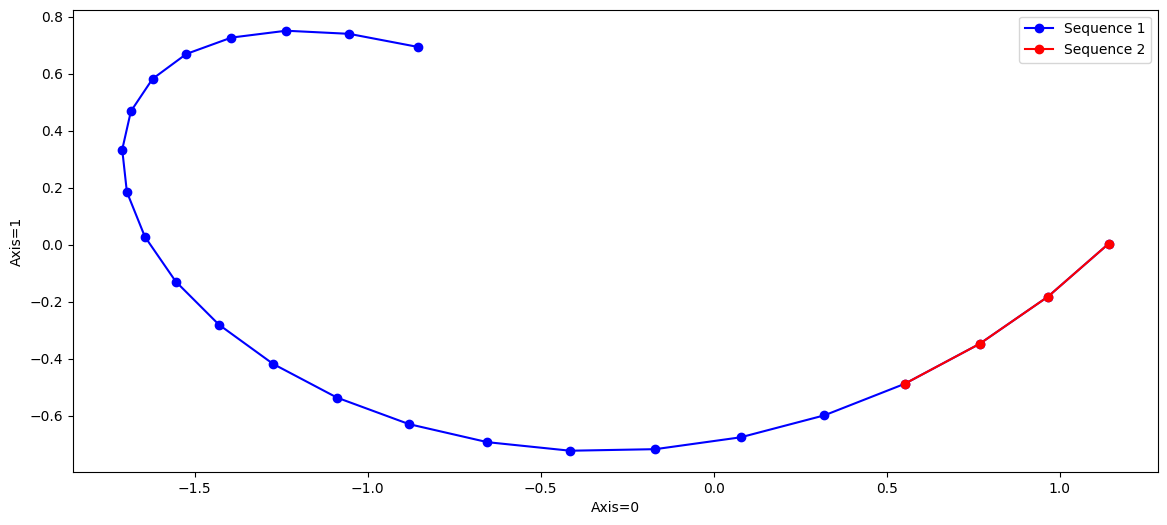

In [147]:
k1, k2 = 20, 4

i = random.randint(0, len(x_train) - k1 - k2)
j = i + k1

segment_2d_pred(x_train[i:j+k2], x_train[j:j+k2], ms=6, save_as='../Images/02-objectives.png')

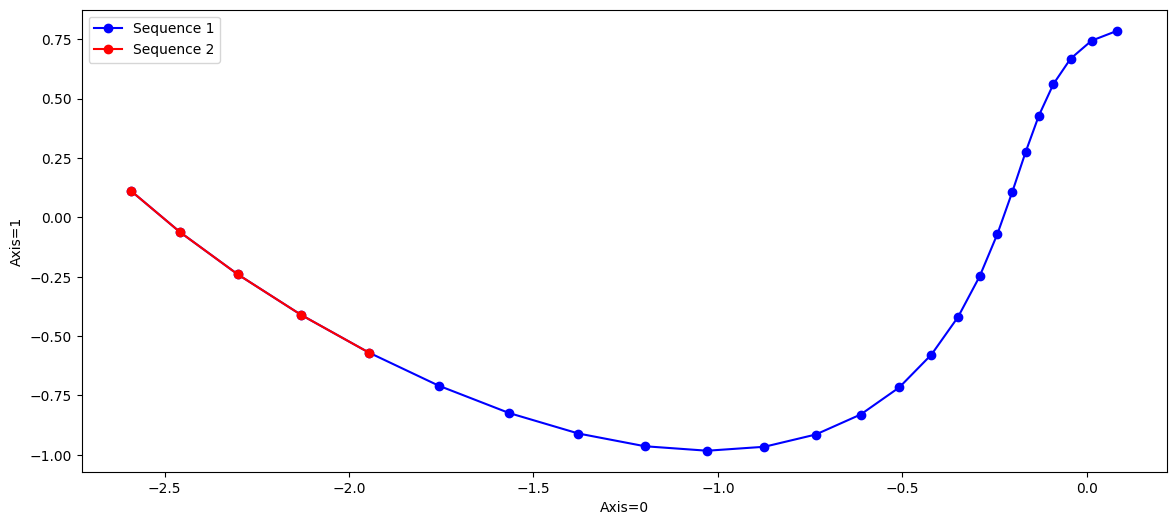

In [148]:
k1,k2 = sequence_len, predict_len
i = random.randint(0,len(x_test)-k1-k2)
j = i+k1

segment_2d_pred(x_test[i:j+k2], x_test[j:j+k2], ms=6, save_as='../Images/02-objective1s.png')


In [149]:
# ---- Create sequences and labels for train and test
#
xs_train, ys_train=[],[]
all_i = np.random.permutation( len(x_train) - sequence_len - 1 )

for i in all_i:
    xs_train.append( x_train[ i : i+sequence_len ] )
    ys_train.append( x_train[ i+sequence_len+1 ]   )
    
xs_test, ys_test=[],[]
for i in range( len(x_test) - sequence_len - 1):
    xs_test.append( x_test[ i : i+sequence_len ] )
    ys_test.append( x_test[ i+sequence_len+1 ]   )

# ---- Convert to numpy / float16
    
xs_train = np.array(xs_train, dtype='float16')
ys_train = np.array(ys_train, dtype='float16')
xs_test  = np.array(xs_test,  dtype='float16')
ys_test  = np.array(ys_test,  dtype='float16')

In [150]:
xs_train = xs_train.reshape(xs_train.shape[0], sequence_len, 2)
xs_test = xs_test.reshape(xs_test.shape[0], sequence_len, 2)


In [151]:
from tensorflow import keras 
from keras.models import Sequential
from keras.layers import Dense , Dropout , GRU ,LSTM


In [152]:
model = Sequential()
model.add(GRU(250, activation="tanh", return_sequences= True , input_shape=(sequence_len, 2)))
model.add(GRU(200, activation="tanh",  input_shape=(sequence_len, 2)))
model.add(Dense(128))
model.add(Dense(64))
model.add(Dense(2))


In [153]:
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_3 (GRU)                     │ (None, 20, 250)        │       190,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_4 (GRU)                     │ (None, 200)            │       271,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │        25,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 495,814 (1.89 MB)

 Trainable params: 495,814 (1.89 MB)

 Non-trainable params: 0 (0.00 B)

In [154]:
model.compile( 
              optimizer = "rmsprop", 
              loss='mse', 
              metrics   = ['mae'] )

In [155]:
len(xs_train.shape)

3

In [156]:
ys_train[0]

array([ 0.3152 , -0.05554], dtype=float16)

In [158]:
history=model.fit(xs_train,ys_train,
                  epochs  = 10, 
                  verbose = 1,
                  validation_data = (xs_test, ys_test),)

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 29s 58ms/step - loss: 0.0025 - mae: 0.0330 - val_loss: 0.0032 - val_mae: 0.0449
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 27s 54ms/step - loss: 0.0023 - mae: 0.0310 - val_loss: 6.6815e-04 - val_mae: 0.0195
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 30s 59ms/step - loss: 0.0023 - mae: 0.0296 - val_loss: 0.0059 - val_mae: 0.0590
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 29s 57ms/step - loss: 0.0019 - mae: 0.0294 - val_loss: 3.9512e-04 - val_mae: 0.0161
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 27s 54ms/step - loss: 0.0016 - mae: 0.0259 - val_loss: 0.0019 - val_mae: 0.0349
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 30s 61ms/step - loss: 0.0017 - mae: 0.0279 - val_loss: 6.8585e-04 - val_mae: 0.0190
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 30s 60ms/step - loss: 0.0016 - mae: 0.0263 - val_loss: 8.0225e-04 - val_mae: 0.0233
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 30s 59ms/step - loss: 0.0014 - mae: 0.0248 - val_loss: 5.9079e-04 - val_mae: 0.0172
Epoch 9/10
500/500 ━

In [159]:
model.predict(xs_test[:2])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step


array([[0.2834065 , 0.15850964],
       [0.45595768, 0.09067625]], dtype=float32)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step
sequence shape      : (20, 2)
sequence true shape : (24, 2)
sequence pred shape : (1, 2)


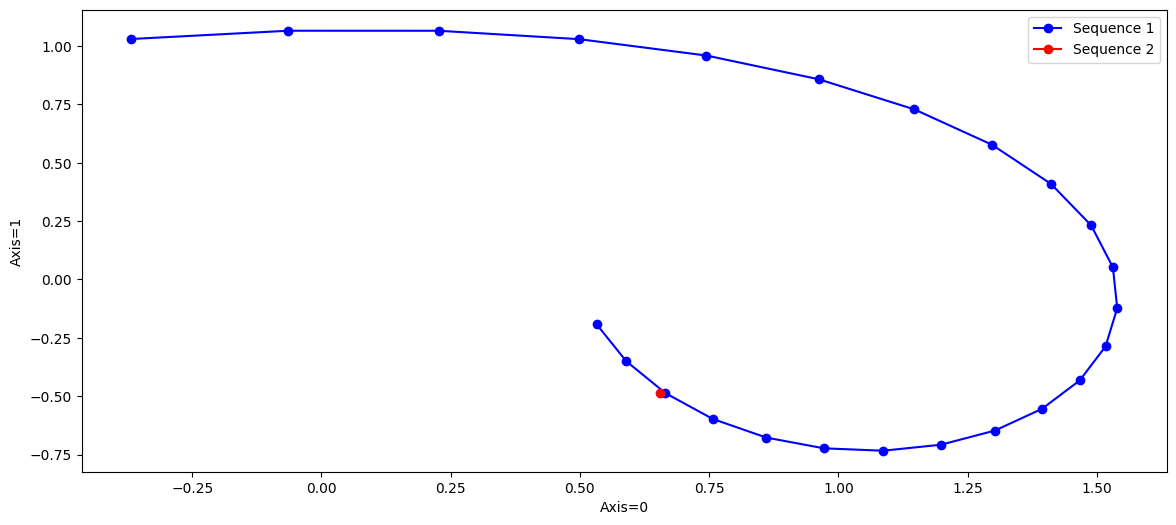

In [161]:


s=random.randint(0,len(x_test)-sequence_len)

sequence      = x_test[s:s+sequence_len]
sequence_true = x_test[s:s+sequence_len+4]

sequence_pred = model.predict( np.array([sequence]), verbose=1 )

print('sequence shape      :',sequence.shape)
print('sequence true shape :',sequence_true.shape)
print('sequence pred shape :',sequence_pred.shape)

segment_2d_pred(sequence_true, sequence_pred, ms=6, save_as='../Images/model_predict.png')



In [162]:
sequence_pred

array([[ 0.65545344, -0.48578516]], dtype=float32)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


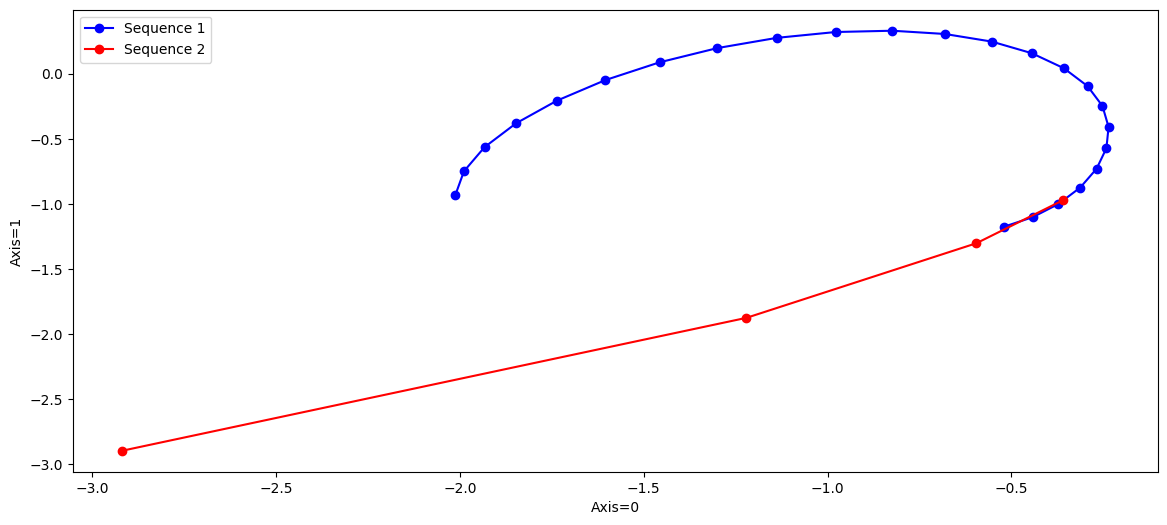

In [177]:
def get_prediction(dataset, model, iterations=4):

 
    s=random.randint(0,len(dataset)-sequence_len-iterations)

    sequence_pred = dataset[s:s+sequence_len].copy()
    sequence_true = dataset[s:s+sequence_len+iterations].copy()

    sequence_pred = list(sequence_pred)

    for i in range(iterations):
        sequence   = sequence_pred[-sequence_len:]
        prediction = model.predict( np.array([sequence]), verbose=1 )
        sequence_pred.append(prediction[0])

    prediction = np.array(sequence_pred[-iterations:])

    return sequence_true,prediction 


sequence_true, sequence_pred = get_prediction(x_test, model, iterations=4)

segment_2d_pred(sequence_true, sequence_pred, ms=6, save_as='../Images/model_predict.png')



In [173]:
model.save("../models/model_Trajectory_GRU_loss_0_0015_mae_0_0234.keras")